In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import pandas_gbq as pd_gbq
import gc
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from matplotlib import pyplot as plt
#from google.cloud import automl_v1beta1 as automl
from google.cloud import bigquery
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import roc_auc_score, roc_curve, auc
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.preprocessing import StandardScaler
import pickle
from tqdm.auto import tqdm
import pyarrow as pa
import pyarrow.parquet as pq
import joblib
import glob
import lightgbm as lgb

from pandas_profiling import ProfileReport


/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage before optimization is: {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


In [3]:
df=pd.read_parquet("train_grouped.parquet")
y=df['target']
df.drop('target',axis=1,inplace=True)

In [4]:
X=reduce_mem_usage(df)

Memory usage before optimization is: 3150.67 MB
Memory usage after optimization is: 1565.05 MB
Decreased by 50.3%


In [5]:
del df
gc.collect

<function gc.collect(generation=2)>

In [6]:
custId=X['customer_ID']

In [7]:
X.drop('customer_ID',axis=1,inplace=True)

In [8]:
scaler = StandardScaler()
X=scaler.fit_transform(X)

Explained variance ratio : [0.0767027  0.03365615 0.0291576 ]


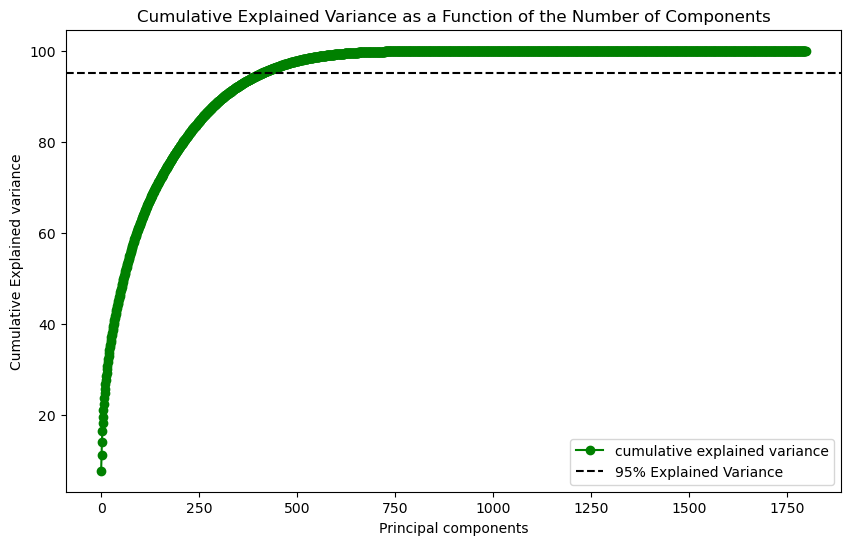

In [9]:
#Using elbow-plot variance/dimensions
pca = PCA()
pca.fit(X)
print('Explained variance ratio : {}'.format(pca.explained_variance_ratio_[0:3]))
cumsum = np.cumsum(pca.explained_variance_ratio_)*100
d = [n for n in range(len(cumsum))]
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(d, cumsum, color = 'green', marker='o', label='cumulative explained variance')
ax.set_title('Cumulative Explained Variance as a Function of the Number of Components')
ax.set_ylabel('Cumulative Explained variance')
ax.set_xlabel('Principal components')
ax.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
ax.legend(loc='best')
plt.savefig('eda5.png')
plt.show()

In [10]:
X_reduced = pca.fit_transform(X)

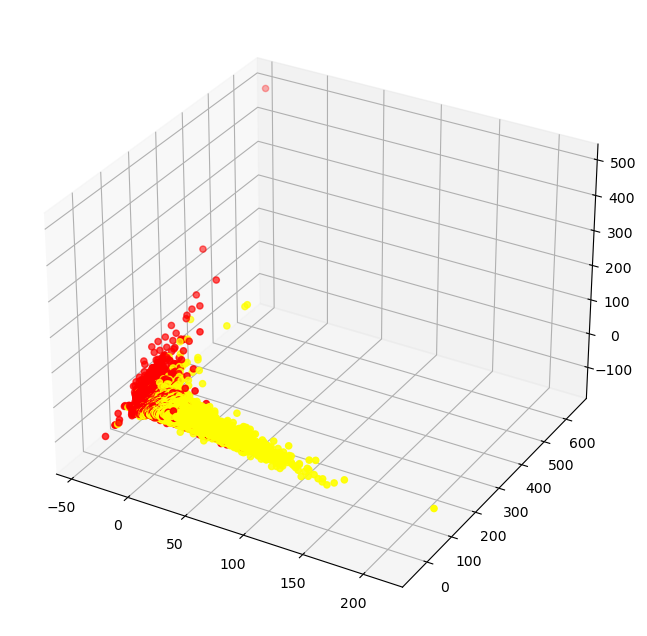

In [11]:
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y, s=20, cmap='autumn')
plt.show()

In [ ]:
'''
#Using elbow-plot variance/dimensions
pca = KernelPCA(kernel="rbf", gamma=0.04)
pca.fit(X)
print('Explained variance ratio : {}'.format(pca.explained_variance_ratio_[0:3]))
cumsum = np.cumsum(pca.explained_variance_ratio_)*100
d = [n for n in range(len(cumsum))]
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(d, cumsum, color = 'green', marker='o', label='cumulative explained variance')
ax.set_title('Cumulative Explained Variance as a Function of the Number of Components')
ax.set_ylabel('Cumulative Explained variance')
ax.set_xlabel('Principal components')
ax.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
ax.legend(loc='best')
plt.savefig('kernelpca.png')
plt.show()'''

In [ ]:
'''X_reduced = pca.fit_transform(X)'''

In [ ]:
'''fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y, s=20, cmap='autumn')
plt.show()'''

In [15]:
X_reduced[:,:500].shape[1]

500

In [16]:
panda_df = pd.DataFrame(data = X_reduced[:,:500],
                        columns = ['Column_' + str(i + 1) 
                        for i in range(X_reduced[:,:500].shape[1])])

In [17]:
panda_df['customer_ID']=custId 
panda_df['target']=y 


In [22]:
num_cols = list(panda_df.dtypes[(panda_df.dtypes == 'float16')].index)
for col in tqdm(num_cols):
    panda_df[col] = panda_df[col].astype(np.float32)
    
table = pa.Table.from_pandas(panda_df)
pqwriter = pq.ParquetWriter("train_grouped_pca.parquet", table.schema) 
pqwriter.write_table(table)
pqwriter.close()

0it [00:00, ?it/s]
